In [2]:
DATA_PATH = 'CDR_Data/BC5CDR-disease/'

In [44]:
!pip install sklearn-crfsuite

In [48]:
import os

from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [34]:
def read_tsv(path):
    result = []
    with open(path) as fp:
        for sent in fp.read().split('\n\n'):
            sent_toks = []
            for tok in sent.strip().split('\n'):
                tok = tok.strip()
                if len(tok) == 0:
                    continue
                tok, tag = tok.split('\t')
                sent_toks.append((tok, tag))
            result.append(sent_toks)
    return result

In [82]:
train_sents = read_tsv(os.path.join(DATA_PATH, 'train.tsv'))
valid_sents = read_tsv(os.path.join(DATA_PATH, 'devel.tsv'))
test_sents = read_tsv(os.path.join(DATA_PATH, 'test.tsv'))

## Features

Next, define some features. In this example we use word identity, word suffix, and word shape; also, some information from nearby words is used.

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [40]:
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

This is what word2features extracts:

In [41]:
sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'selegiline',
 'word[-3:]': 'ine',
 'word[-2:]': 'ne',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'BOS': True,
 '+1:word.lower()': '-',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False}

Extract features from the data:

In [83]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_valid = [sent2features(s) for s in valid_sents]
y_valid = [sent2labels(s) for s in valid_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 896 ms, sys: 87 ms, total: 983 ms
Wall time: 1.03 s


## Training

To see all possible CRF parameters check its docstring. 
Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [49]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 6.51 s, sys: 209 ms, total: 6.72 s
Wall time: 7.46 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

In [50]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B', 'I']

In [53]:
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred, average='weighted', labels=labels)

0.7310617603143285

In [54]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           B      0.847     0.702     0.768      4246
           I      0.744     0.615     0.674      2723

   micro avg      0.807     0.668     0.731      6969
   macro avg      0.796     0.659     0.721      6969
weighted avg      0.807     0.668     0.731      6969



## Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 5-fold cross-validation.

I takes quite a lot of CPU time and RAM (we’re fitting a model 50 * 5 = 250 times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [56]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 31.0min finished


CPU times: user 28min 39s, sys: 23 s, total: 29min 2s
Wall time: 31min 4s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   iid='deprecated', n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb0447a050>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb0447ad90>},
                

## Check parameter space

A chart which shows which c1 and c2 values have RandomizedSearchCV checked. Red color means better results, blue means worse.

No handles with labels found to put in legend.


Dark blue => 0.6099, dark red => 0.7093


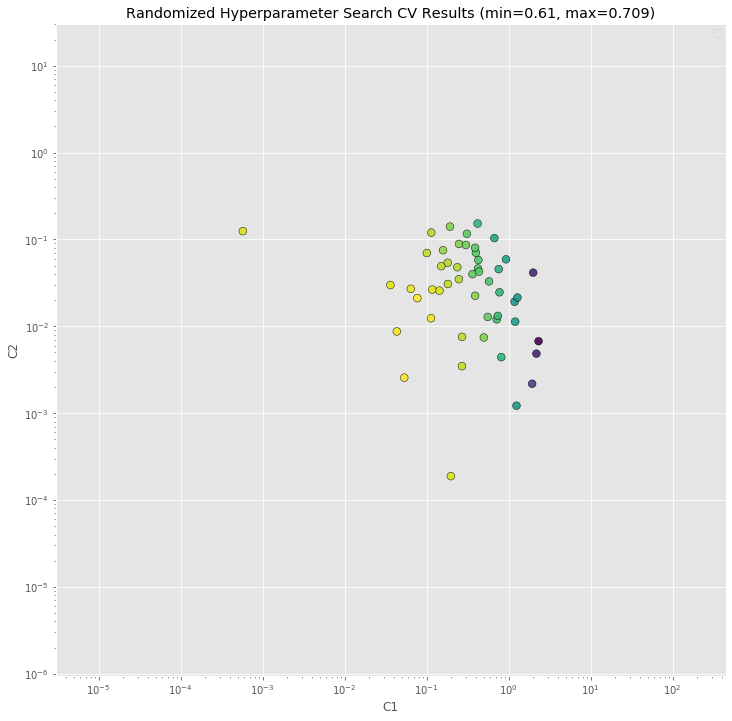

In [75]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = rs.cv_results_['mean_test_score']

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

plt.legend()
plt.show()

## Check best estimator on our test data

As you can see, quality is improved.

In [84]:
crf = rs.best_estimator_

y_pred = crf.predict(X_test)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           B      0.823     0.713     0.764      4424
           I      0.737     0.638     0.684      2737

   micro avg      0.790     0.685     0.734      7161
   macro avg      0.780     0.676     0.724      7161
weighted avg      0.790     0.685     0.734      7161



## Let’s check what classifier learned

In [78]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I      -> I       2.366779
O      -> O       2.342699
B      -> I       0.989838
O      -> B       0.396911
I      -> O       -1.556073
B      -> O       -1.945218
I      -> B       -5.019857
B      -> B       -5.954035
O      -> I       -9.107979

Top unlikely transitions:
I      -> I       2.366779
O      -> O       2.342699
B      -> I       0.989838
O      -> B       0.396911
I      -> O       -1.556073
B      -> O       -1.945218
I      -> B       -5.019857
B      -> B       -5.954035
O      -> I       -9.107979


We can see that, for example, it is very likely that the beginning of a token will be followed by a token inside organization name, but transitions to intermediate to begining are penalized.

Check the state features:

In [80]:
def print_state_features(state_features):
    for (attr, label), weight in state_features[:5]:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
11.476029 B        word.lower():migraine
10.808846 B        word.lower():depressed
10.139518 B        word.lower():seizure
9.900440 B        word.lower():pain
9.555320 B        word[-3:]:aly

Top negative:
-3.418675 O        -1:word.lower():dbp
-3.424317 B        word.isdigit()
-3.442182 O        +1:word.lower():encountered
-3.458825 O        word.lower():death
-3.468774 B        word[-2:]:he
